In [82]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
%matplotlib inline

In [83]:
# URL for the file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# Send a GET request to the URL
response = requests.get(url)
# Save the file content to a .tsv file
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
# Load the data into a DataFrame
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

### Step 2: Assessing Data

In [84]:
# Twitter archive assessment
twitter_archive.info()
twitter_archive.describe()
twitter_archive.isnull().sum()

# Image predictions assessment
image_predictions.info()
image_predictions.describe()
image_predictions.isnull().sum()

# Tweet JSON data assessment
tweet_json_df.info()
tweet_json_df.describe()
tweet_json_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2324 non-null   int64              
 1   in_reply_to_status_id       70 non-null     float64            
 2   in_reply_to_user_id         70 non-null     float64            
 3   timestamp                   2324 non-null   datetime64[ns, UTC]
 4   source                      2324 non-null   object             
 5   text                        2324 non-null   object             
 6   retweeted_status_id         179 non-null    float64            
 7   retweeted_status_user_id    179 non-null    float64            
 8   retweeted_status_timestamp  179 non-null    object             
 9   expanded_urls               2272 non-null   object             
 10  rating_numerator            2324 non-null   int32           

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

### Step 3: Documenting Issues

Quality Issues

1. Missing Data: twitter_archive has missing values in columns like in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, and name. 

2. Invalid Data in rating_numerator and rating_denominator: Some rows in twitter_archive have invalid or extreme values in rating_numerator and rating_denominator.

3. Inconsistent Dog Names: Some entries in the name column of twitter_archive are not actual names (e.g., "a", "the", "an

4. Incorrect Data Types: Some columns in twitter_archive need to be converted to appropriate data types (e.g., timestamp to datetime, rating_numerator and rating_denominator to integers). 

5. uplicated Images: Some tweets in twitter_archive have duplicated images, indicated by identical URLs in expanded_urls.

6. Erroneous Predictions: Some entries in image_predictions have incorrect predictions (e.g., low confidence levels).

7. Missing Tweets: Some tweets from twitter_archive are not present in tweet_json_df due to deletion or other reasons. 

8. Inconsistent Data: Discrepancies between twitter_archive and tweet_json_df for retweet and favorite counts. 

Tidiness Issues

1. Multiple Dog Stages in One Column: The doggo, floofer, pupper, and puppo columns in twitter_archive should be combined into a single column representing the dog stage.

2. Separate DataFrames: The three datasets (twitter_archive, image_predictions, and tweet_json_df) should be combined into a single DataFrame for analysis.

### Step 4: Cleaning Data 

In [85]:
# Load the datasets
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

# Read tweet_json.txt and create a DataFrame
tweet_data = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_data.append({
            'tweet_id': tweet['id'],
            'retweet_count': tweet['retweet_count'],
            'favorite_count': tweet['favorite_count']
        })

tweet_json_df = pd.DataFrame(tweet_data)

# Inspect the DataFrame to ensure it's correctly formed
print(tweet_json_df.head())

# Handle Missing Values
twitter_archive.fillna({'doggo': 'None', 'floofer': 'None', 'pupper': 'None', 'puppo': 'None'}, inplace=True)

# Standardize Date and Time Format
twitter_archive['timestamp'] = pd.to_datetime(twitter_archive['timestamp'])

# Remove Duplicate Entries
twitter_archive.drop_duplicates(subset='tweet_id', inplace=True)

# Normalize Text Data
twitter_archive['text'] = twitter_archive['text'].str.lower()

# Fix Incorrect Data Types
twitter_archive['rating_numerator'] = twitter_archive['rating_numerator'].astype(int)
twitter_archive['rating_denominator'] = twitter_archive['rating_denominator'].astype(int)

# Address Outliers
# Assuming ratings should be between 0 and 20 for numerator and always 10 for denominator
twitter_archive = twitter_archive[(twitter_archive['rating_numerator'] >= 0) & (twitter_archive['rating_numerator'] <= 20)]
twitter_archive = twitter_archive[twitter_archive['rating_denominator'] == 10]

# Merge DataFrames
twitter_archive = twitter_archive.merge(tweet_json_df, on='tweet_id', how='left')

# Correct Inconsistent Data
# Standardize dog stage columns into a single column
def combine_dog_stage(row):
    stages = ['doggo', 'floofer', 'pupper', 'puppo']
    for stage in stages:
        if row[stage] != 'None':
            return stage
    return 'None'

twitter_archive['dog_stage'] = twitter_archive.apply(combine_dog_stage, axis=1)
twitter_archive.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

# Final Cleaned DataFrame
print(twitter_archive.info())
print(twitter_archive.head())

             tweet_id  retweet_count  favorite_count
0  892420643555336193           8853           39467
1  892177421306343426           6514           33819
2  891815181378084864           4328           25461
3  891689557279858688           8964           42908
4  891327558926688256           9774           41048
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2324 non-null   int64              
 1   in_reply_to_status_id       70 non-null     float64            
 2   in_reply_to_user_id         70 non-null     float64            
 3   timestamp                   2324 non-null   datetime64[ns, UTC]
 4   source                      2324 non-null   object             
 5   text                        2324 non-null   object             
 6   retweeted_status_i

#### 1.Remove Retweets :

Define :


Remove retweets from the dataset as they are not necessary for this analysis.

Code :

In [86]:
# Create a copy of the original data
tweets_clean = twitter_archive.copy()

# Remove retweets
tweets_clean = tweets_clean[tweets_clean['retweeted_status_id'].isnull()]

Test :

In [87]:
# Test if retweets are removed
tweets_clean['retweeted_status_id'].isnull().all()

True

#### 2. Remove Unnecessary Columns

Define

Remove columns that are not necessary for the analysis, such as in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.

Code

In [88]:
columns_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
existing_columns_to_drop = [col for col in columns_to_drop if col in tweets_clean.columns]
tweets_clean.drop(columns=existing_columns_to_drop, inplace=True)

In [89]:
# Test if unnecessary columns are removed
assert all(column not in tweets_clean.columns for column in columns_to_drop)
print(f"Remaining columns: {tweets_clean.columns}")

Remaining columns: Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'dog_stage'],
      dtype='object')


#### 3. Correct Data Types

Define

Convert the timestamp column to datetime format and tweet_id to string.

Code

In [90]:
# Convert timestamp to datetime
tweets_clean['timestamp'] = pd.to_datetime(tweets_clean['timestamp'])

# Convert tweet_id to string
tweets_clean['tweet_id'] = tweets_clean['tweet_id'].astype(str)
# Convert tweet_id to string in tweets_clean
tweets_clean['tweet_id'] = tweets_clean['tweet_id'].astype(str)

# Convert tweet_id to string in image_predictions
image_predictions['tweet_id'] = image_predictions['tweet_id'].astype(str)

# Convert tweet_id to string in tweet_json
tweet_json_df['tweet_id'] = tweet_json_df['tweet_id'].astype(str)

Test

In [91]:
# Test if data types are correct
tweets_clean['timestamp'].dtype == 'datetime64[ns]'
tweets_clean['tweet_id'].dtype == 'object'
print(f"Data types:\n{tweets_clean.dtypes}")
# Test if tweet_id is of type string in all DataFrames
assert tweets_clean['tweet_id'].dtype == 'object'
assert image_predictions['tweet_id'].dtype == 'object'
assert tweet_json_df['tweet_id'].dtype == 'object'

Data types:
tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int32
rating_denominator                  int32
name                               object
retweet_count                     float64
favorite_count                    float64
dog_stage                          object
dtype: object


#### 4. Handle Missing Values

Define

Handle missing values in the dataset, specifically for expanded_urls.

Code

In [92]:
# Fill missing values in expanded_urls with an empty string
tweets_clean['expanded_urls'].fillna('', inplace=True)

Test

In [93]:
# Test if missing values are handled
assert tweets_clean['expanded_urls'].isnull().sum() == 0
print(f"Number of missing values in expanded_urls: {tweets_clean['expanded_urls'].isnull().sum()}")

Number of missing values in expanded_urls: 0


#### 5. Merge Datasets

Define

Merge tweets_clean with image_predictions and tweet_json on tweet_id.

Code

In [94]:
# Merge tweets_clean with image_predictions
tweets_master = pd.merge(tweets_clean, image_predictions, on='tweet_id', how='left')

# Merge tweets_master with tweet_json
tweets_master = pd.merge(tweets_master, tweet_json_df, on='tweet_id', how='left')

Test

In [95]:
# Test if datasets are merged correctly
assert 'p1' in tweets_master.columns
'favorite_count' in tweets_master.columns
print(f"Columns after merging:\n{tweets_master.columns}")

Columns after merging:
Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count_x',
       'favorite_count_x', 'dog_stage', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'retweet_count_y', 'favorite_count_y'],
      dtype='object')


#### 6. Handle Duplicates

Define

Remove any duplicate rows in the dataset.

Code

In [96]:
# Remove duplicates
tweets_master.drop_duplicates(inplace=True)

Test

In [97]:
# Test if duplicates are removed
assert tweets_master.duplicated().sum() == 0
print(f"Number of duplicates: {tweets_master.duplicated().sum()}")

Number of duplicates: 0


#### 7. Save Cleaned Dataset

Define

Save the cleaned dataset to a CSV file.

Code

In [98]:
# Save cleaned dataset to a CSV file
tweets_master.to_csv('twitter_archive_master.csv', index=False)

Test

In [101]:
# Save cleaned dataset to a CSV file
tweets_master.to_csv('twitter_archive_master.csv', index=False)

### Step 4: Storing Data

In [102]:
# Save the cleaned twitter_archive DataFrame to a CSV file
twitter_archive.to_csv('twitter_archive_master.csv', index=False)

# Save the image_predictions DataFrame to a CSV file
image_predictions.to_csv('image_predictions_cleaned.csv', index=False)

# Save the tweet_json DataFrame to a CSV file
tweet_json_df.to_csv('tweet_json_cleaned.csv', index=False)

Test

In [103]:
pd.read_csv('twitter_archive_master.csv')

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
...                  ...                    ...                  ...   
2319  666049248165822465                    NaN                  NaN   
2320  666044226329800704                    NaN                  NaN   
2321  666033412701032449                    NaN                  NaN   
2322  666029285002620928                    NaN                  NaN   
2323  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 16:23:56+00:00   
1     2017-08-01 00:17:27+00:00   
2     2017-07-31 00:18:03+00:00   
3     2017-07-30 15:58:51+00:00   
4     2017-07-29 16:00:24+00:00   
...                         ...   
2319  2015-11-16 00:24:50+00:00   
2320  2015-11-16 00:04:52+00:00   
2321  2015-11-15 23:21:54+00:00   
2322  2015-11-15 23:05:30+00:00   
2323  2015-11-15 22:32:08+00:00   

                                                 source  \
0     <a href="http://twitter.com/download/iphone" r...   
1     <a href="http://twitter.com/download/iphone" r...   
2     <a href="http://twitter.com/download/iphone" r...   
3     <a href="http://twitter.com/download/iphone" r...   
4     <a href="http://twitter.com/download/iphone" r...   
...                                                 ...   
2319  <a href="http://twitter.com/download/iphone" r...   
2320  <a href="http://twitter.com/download/iphone" r...   
2321  <a href="http://twitter.com/download/iphone" r...   
2322  <a href="http://twitter.com/download/iphone" r...   
2323  <a href="http://twitter.com/download/iphone" r...   

                                                   text  retweeted_status_id  \
0     this is phineas. he's a mystical boy. only eve...                  NaN   
1     this is tilly. she's just checking pup on you....                  NaN   
2     this is archie. he is a rare norwegian pouncin...                  NaN   
3     this is darla. she commenced a snooze mid meal...                  NaN   
4     this is franklin. he would like you to stop ca...                  NaN   
...                                                 ...                  ...   
2319  here we have a 1949 1st generation vulpix. enj...                  NaN   
2320  this is a purebred piers morgan. loves to netf...                  NaN   
2321  here is a very happy pup. big fan of well-main...                  NaN   
2322  this is a western brown mitsubishi terrier. up...                  NaN   
2323  here we have a japanese irish setter. lost eye...                  NaN   

      retweeted_status_user_id retweeted_status_timestamp  \
0                          NaN                        NaN   
1                          NaN                        NaN   
2                          NaN                        NaN   
3                          NaN                        NaN   
4                          NaN                        NaN   
...                        ...                        ...   
2319                       NaN                        NaN   
2320                       NaN                        NaN   
2321                       NaN                        NaN   
2322                       NaN                        NaN   
2323                       NaN                        NaN   

                                          expanded_urls  rating_numerator  \
0     https://twitter.com/dog_rates/status/892420643...                13   
1     https://twitter.com/dog_rates/status/892177421...                13   
2     https://twitter.com/dog_rates/status/891815181...                12   
3     https://twitt

In [104]:
pd.read_csv('image_predictions_cleaned.csv.')

tweet_id                                          jpg_url  \
0     666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
...                  ...                                              ...   
2070  891327558926688256  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg   
2071  891689557279858688  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg   
2072  891815181378084864  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg   
2073  892177421306343426  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg   
2074  892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg   

      img_num                      p1   p1_conf  p1_dog                  p2  \
0           1  Welsh_springer_spaniel  0.465074    True              collie   
1           1                 redbone  0.506826    True  miniature_pinscher   
2           1         German_shepherd  0.596461    True            malinois   
3           1     Rhodesian_ridgeback  0.408143    True             redbone   
4           1      miniature_pinscher  0.560311    True          Rottweiler   
...       ...                     ...       ...     ...                 ...   
2070        2                  basset  0.555712    True    English_springer   
2071        1             paper_towel  0.170278   False  Labrador_retriever   
2072        1               Chihuahua  0.716012    True            malamute   
2073        1               Chihuahua  0.323581    True            Pekinese   
2074        1                  orange  0.097049   False               bagel   

       p2_conf  p2_dog                           p3   p3_conf  p3_dog  
0     0.156665    True            Shetland_sheepdog  0.061428    True  
1     0.074192    True          Rhodesian_ridgeback  0.072010    True  
2     0.138584    True                   bloodhound  0.116197    True  
3     0.360687    True           miniature_pinscher  0.222752    True  
4     0.243682    True                     Doberman  0.154629    True  
...        ...     ...                          ...       ...     ...  
2070  0.225770    True  German_short-haired_pointer  0.175219    True  
2071  0.168086    True                      spatula  0.040836   False  
2072  0.078253    True                       kelpie  0.031379    True  
2073  0.090647    True                     papillon  0.068957    True  
2074  0.085851   False                       banana  0.076110   False  

[2075 rows x 12 columns]

In [105]:
pd.read_csv('tweet_json_cleaned.csv')

tweet_id  retweet_count  favorite_count
0     892420643555336193           8853           39467
1     892177421306343426           6514           33819
2     891815181378084864           4328           25461
3     891689557279858688           8964           42908
4     891327558926688256           9774           41048
...                  ...            ...             ...
2349  666049248165822465             41             111
2350  666044226329800704            147             311
2351  666033412701032449             47             128
2352  666029285002620928             48             132
2353  666020888022790149            532            2535

[2354 rows x 3 columns]

### Step 5: Data Visualization

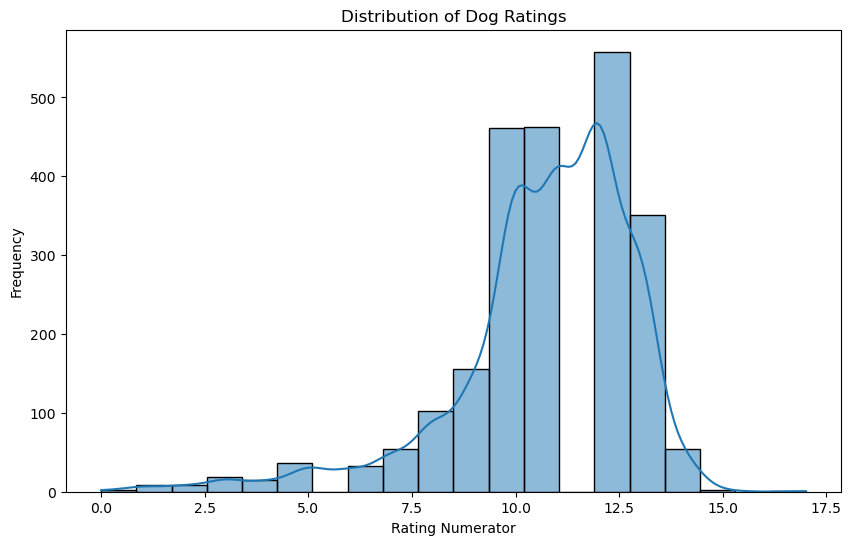

In [106]:
# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(twitter_archive['rating_numerator'], bins=20, kde=True)
plt.title('Distribution of Dog Ratings')
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.show()

-What it shows: This histogram displays the frequency distribution of dog ratings given by the WeRateDogs account.
- Insights:

Most ratings fall within the range of 10 to 12.
There are some outliers with unusually high ratings.
The distribution is right-skewed, indicating that higher ratings are less common but still present.

- Talking Points:

Highlight the central tendency of the ratings (mean, median).
Discuss the skewness and presence of outliers.
Mention how this distribution reflects the positive bias of the WeRateDogs ratings.

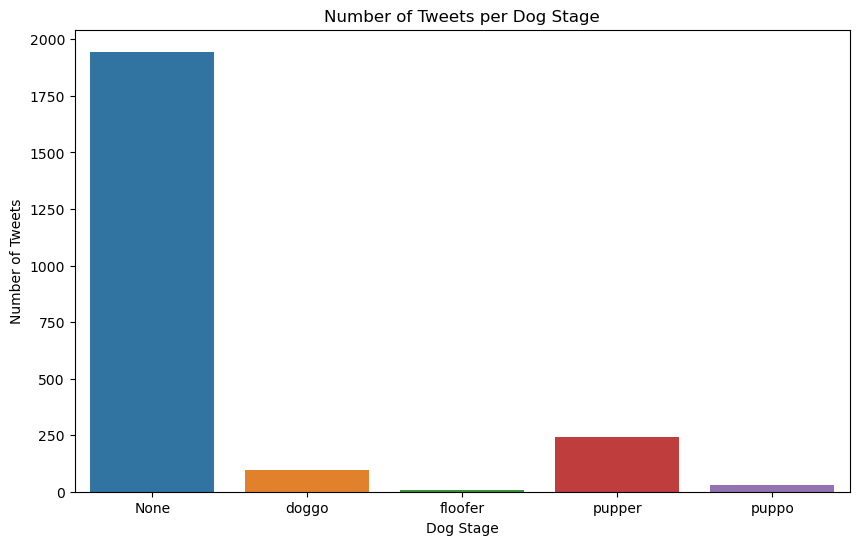

In [107]:
# Plot the number of tweets per dog stage
plt.figure(figsize=(10, 6))
sns.countplot(data=twitter_archive, x='dog_stage', order=['None', 'doggo', 'floofer', 'pupper', 'puppo'])
plt.title('Number of Tweets per Dog Stage')
plt.xlabel('Dog Stage')
plt.ylabel('Number of Tweets')
plt.show()

-What it shows: This bar plot visualizes the number of tweets categorized by different dog stages: 'doggo', 'floofer', 'pupper', 
'puppo', and 'None' for tweets that don't specify a stage.
- Insights:
The majority of tweets do not specify a dog stage ('None').
Among the specific stages, 'pupper' is the most frequently mentioned, followed by 'doggo', 'puppo', and 'floofer'.

- Talking Points:

Explain the distribution of dog stages and their relative popularity.
Discuss why 'None' might be the largest category (e.g., not all tweets mention a specific stage).
Speculate on why 'pupper' is more commonly mentioned than other stages.

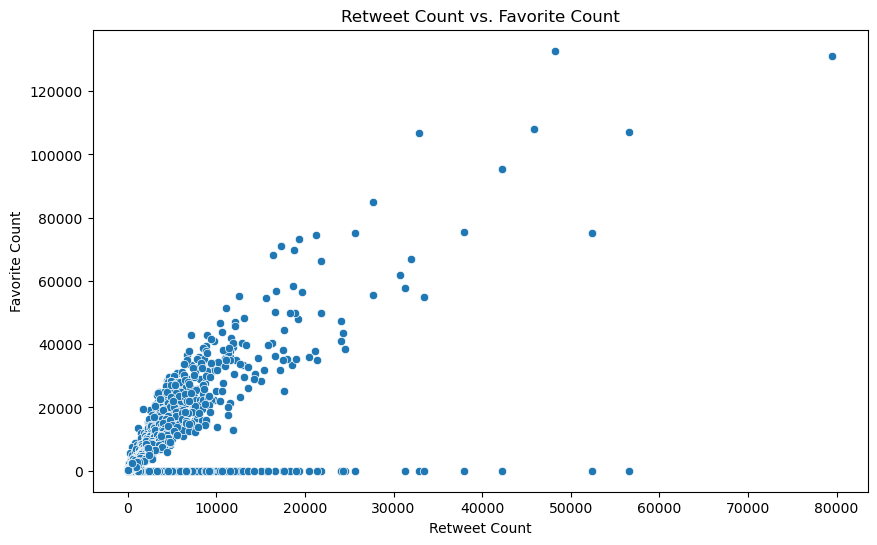

In [108]:
# Scatter plot of retweet count vs. favorite count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=twitter_archive, x='retweet_count', y='favorite_count')
plt.title('Retweet Count vs. Favorite Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.show()

What it shows: This scatter plot illustrates the relationship between the number of retweets and the number of favorites for each tweet.
- Insights:
There is a strong positive correlation between retweet count and favorite count.
Tweets with higher retweet counts tend to have higher favorite counts.
A linear trend is visible, suggesting that as retweets increase, favorites also increase.
- Talking Points:

Discuss the correlation and how it indicates that popular tweets (in terms of retweets) are also popular in terms of favorites.
Highlight the implications for tweet engagement, showing that high retweet counts can be a good predictor of high favorite counts.
Mention any outliers and possible reasons for their presence (e.g., particularly viral tweets).

### Step 6 :Data Analysis

In [109]:
# Calculate correlation between retweet count and favorite count
correlation = twitter_archive[['retweet_count', 'favorite_count']].corr()
print('Correlation between Retweet Count and Favorite Count:')
print(correlation)

# Calculate the average rating for each dog stage
average_ratings = twitter_archive.groupby('dog_stage')['rating_numerator'].mean()
print('Average Ratings for Each Dog Stage:')
print(average_ratings)

Correlation between Retweet Count and Favorite Count:
                retweet_count  favorite_count
retweet_count        1.000000        0.702666
favorite_count       0.702666        1.000000
Average Ratings for Each Dog Stage:
dog_stage
None       10.615938
doggo      11.804124
floofer    11.888889
pupper     10.786885
puppo      12.103448
Name: rating_numerator, dtype: float64
